## Using weather data for the NN

We use similar architectures to develop our NN predictions.
First we import the nesessary libraries and then we use pandas for the dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from keras.optimizers import Adam
from keras.losses import mean_squared_error
import os

Using TensorFlow backend.


In [2]:
cwd = os.getcwd()
os.chdir(r'C:\\Users\\ekoulier\\Desktop\\GGD\\New Data\\Central_Folder')
weather = pd.read_csv('weather_data.csv')
data = pd.read_csv('br_regions_gt.csv')
del data['Unnamed: 0']
os.chdir(cwd)

Now we merge the datasets.

In [3]:
complete_data = pd.merge(data, weather, on = 'Date')
complete_data.head()

,HVB,Date,WB,BZO,Trends,Eindhoven,Gilze-Rijen,Volkel,Woensdrecht
0,29,2004-01,3,20,0,3.303226,3.516129,3.335484,3.696774
1,26,2004-02,12,11,0,4.634483,4.879310,4.444828,4.844828
2,43,2004-03,5,23,57,5.900000,5.977419,5.696774,5.877419
3,22,2004-04,8,44,47,10.803333,10.513333,10.470000,10.226667
4,41,2004-05,18,39,0,12.467742,12.348387,12.406452,11.893548


In [4]:
def create_lag(df, n_lags):
    """
    Manipulates the dataset in order to create time lags for 'HVB', 'WB', 'BZO' and 'Trends'.
    """
    
    assert type(n_lags) == int
 
    for i in df.columns.tolist():
        for j in range(1, n_lags + 1):
            df[i+'-'+str(j)] = df[i].shift(j)
        df[i+'+1'] = df[i].shift(-1)
        
    # We dont need to forecast the google trends    
    del df['Trends+1']
    
    # Due to the shift that creates nans, we delete the first n_lags rows and the last row.
    df = df[n_lags:].reset_index(drop = True)
    df = df[:-1]
    
    return df

In [5]:
complete_data = create_lag(complete_data, 3)

In [6]:
complete_data.columns

Index(['HVB', 'Date', 'WB', 'BZO', 'Trends', 'Eindhoven', 'Gilze-Rijen',
       'Volkel', 'Woensdrecht', 'HVB-1', 'HVB-2', 'HVB-3', 'HVB+1', 'Date-1',
       'Date-2', 'Date-3', 'Date+1', 'WB-1', 'WB-2', 'WB-3', 'WB+1', 'BZO-1',
       'BZO-2', 'BZO-3', 'BZO+1', 'Trends-1', 'Trends-2', 'Trends-3',
       'Eindhoven-1', 'Eindhoven-2', 'Eindhoven-3', 'Eindhoven+1',
       'Gilze-Rijen-1', 'Gilze-Rijen-2', 'Gilze-Rijen-3', 'Gilze-Rijen+1',
       'Volkel-1', 'Volkel-2', 'Volkel-3', 'Volkel+1', 'Woensdrecht-1',
       'Woensdrecht-2', 'Woensdrecht-3', 'Woensdrecht+1'],
      dtype='object')

In [7]:
X = complete_data[['HVB', 'HVB-1', 'HVB-2', 'HVB-3',  
          'WB', 'WB-1', 'WB-2', 'WB-3', 
          'BZO', 'BZO-1', 'BZO-2', 'BZO-3', 
          'Trends', 'Trends-1', 'Trends-2',
          'Gilze-Rijen', 'Gilze-Rijen-1', 'Gilze-Rijen-2']]

y = complete_data[['HVB+1', 'WB+1', 'BZO+1']]

In [8]:
X_T, X_test, y_T, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_T, y_T, test_size = 0.15, shuffle = True)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [10]:
np.random.seed(2)

In [81]:
model_1a = Sequential()

# First layer
model_1a.add(Dense(X_train.shape[1] - 12, input_dim = X_train.shape[1]))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.15))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_1a.add(Dense(X_train.shape[1] - 10))
model_1a.add(Activation('linear'))
#model_1a.add(Dropout(0.15))

model_1a.add(Dense(X_train.shape[1] - 10))
model_1a.add(Activation('linear'))

# Final layer
model_1a.add(Dense(y_train.shape[1]))

# Print the parameters
model_1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 6)                 114       
_________________________________________________________________
activation_31 (Activation)   (None, 6)                 0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 56        
_________________________________________________________________
activation_32 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 72        
_________________________________________________________________
activation_33 (Activation)   (None, 8)                 0         
__________

In [88]:
H = model_1a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])
H = model_1a.fit(X_train, y_train, epochs =  80,  validation_data = (X_val, y_val))

Train on 91 samples, validate on 17 samples
Epoch 1/80
91/91 [==============================] - 1s 7ms/step - loss: 500.2444 - mean_squared_error: 500.2444 - acc: 0.7692 - val_loss: 243.6694 - val_mean_squared_error: 243.6694 - val_acc: 0.5882
Epoch 2/80
91/91 [==============================] - 0s 83us/step - loss: 577.4219 - mean_squared_error: 577.4219 - acc: 0.7582 - val_loss: 243.3352 - val_mean_squared_error: 243.3352 - val_acc: 0.5882
Epoch 3/80
91/91 [==============================] - 0s 82us/step - loss: 565.8574 - mean_squared_error: 565.8574 - acc: 0.7912 - val_loss: 243.3631 - val_mean_squared_error: 243.3631 - val_acc: 0.5882
Epoch 4/80
91/91 [==============================] - 0s 94us/step - loss: 541.5739 - mean_squared_error: 541.5739 - acc: 0.7692 - val_loss: 245.7501 - val_mean_squared_error: 245.7501 - val_acc: 0.5882
Epoch 5/80
91/91 [==============================] - 0s 66us/step - loss: 518.6128 - mean_squared_error: 518.6128 - acc: 0.8022 - val_loss: 241.4476 - val

91/91 [==============================] - 0s 72us/step - loss: 409.9196 - mean_squared_error: 409.9196 - acc: 0.7912 - val_loss: 191.9706 - val_mean_squared_error: 191.9706 - val_acc: 0.5882
Epoch 42/80
91/91 [==============================] - 0s 92us/step - loss: 379.0172 - mean_squared_error: 379.0172 - acc: 0.8022 - val_loss: 192.8618 - val_mean_squared_error: 192.8618 - val_acc: 0.5882
Epoch 43/80
91/91 [==============================] - ETA: 0s - loss: 381.9067 - mean_squared_error: 381.9067 - acc: 0.71 - 0s 66us/step - loss: 359.8621 - mean_squared_error: 359.8621 - acc: 0.7802 - val_loss: 193.3061 - val_mean_squared_error: 193.3061 - val_acc: 0.5882
Epoch 44/80
91/91 [==============================] - 0s 88us/step - loss: 402.7879 - mean_squared_error: 402.7879 - acc: 0.8022 - val_loss: 192.8452 - val_mean_squared_error: 192.8452 - val_acc: 0.5882
Epoch 45/80
91/91 [==============================] - 0s 77us/step - loss: 381.6655 - mean_squared_error: 381.6655 - acc: 0.7912 - val_

91/91 [==============================] - 0s 71us/step - loss: 367.2356 - mean_squared_error: 367.2356 - acc: 0.7912 - val_loss: 164.6568 - val_mean_squared_error: 164.6568 - val_acc: 0.5882


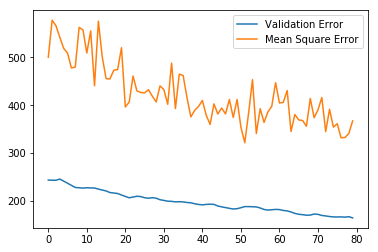

In [89]:
plt.plot(H.history['val_mean_squared_error'], label = 'Validation Error')
plt.plot(H.history['mean_squared_error'], label = 'Mean Square Error' )
plt.legend()
plt.show()

In [90]:
predictions = np.round(model_1a.predict(X_test))

In [91]:
np_y_test = np.array(y_test)

In [92]:
print(r2_score(predictions, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO']):
    print(j, 'R2 score :', r2_score(predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

-0.104918347712
HVB R2 score : 0.322094399628 Mean Absolute Error 12.2962962963
WB  R2 score : -1.00970342636 Mean Absolute Error 11.7962962963
BZO R2 score : 0.372853983594 Mean Absolute Error 7.12962962963


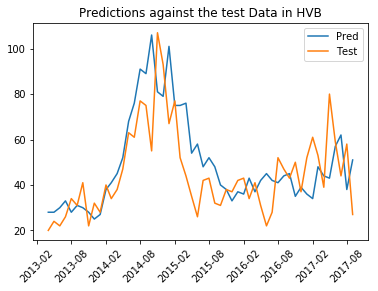

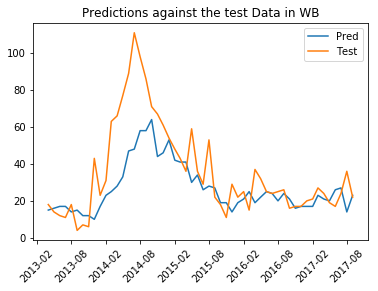

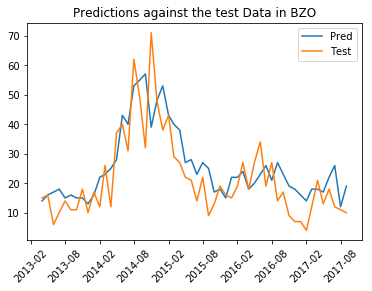

In [93]:
prediction_dataframe = pd.DataFrame({'Date' : complete_data['Date'][-len(y_test):], 
                         'HVB':predictions[:,0],
                       'WB': predictions[:,1],
                       'BZO': predictions[:,2]}).reset_index(drop = True)
prediction_dataframe['Date'] = pd.to_datetime(prediction_dataframe['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO']:
    plt.plot(prediction_dataframe['Date'], prediction_dataframe[i], label = 'Pred'  )
    plt.plot(prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NNζ'+i)
    plt.show()